In [1]:
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt

from ray import tune


In [2]:
df = pd.read_csv('./data.csv')

# Data Preparation

In [3]:
# For simplicity, we only trade a single stock.
ticker = '1332 JT'

trade_df = df[df.ticker == ticker].copy()
trade_df.set_index('date')
trade_df.index = pd.to_datetime(trade_df.date, infer_datetime_format=True)
trade_df.fillna(method='ffill')
trade_df.drop_duplicates()

trade_df['price_change_pct'] = (trade_df['last'] - trade_df['last'].shift(1)) / trade_df['last'].shift(1)
trade_df['prev_volume'] = trade_df['volume'].shift(1)
trade_df['price_change_pct'].fillna(0, inplace=True)
trade_df['prev_volume'].fillna(method='bfill', inplace=True)

# Implementation of the Strategy

## Basic Idea
* Apply the XGBoost to predict the today's price change given the historical data until today.
* Select some features based on the data, e.g., the day of the week.
* Perform hyperparameter tunning to select out the best configuration. The selection is based on the performance of the XGBoost on validation data.
* Use the XGBoost fitted on the historical data with the best hyperparameter to predict the price change today.
* If the predicted price change is positive, then we will increase our position; If the predicted price change is negative, then we will decrease our position.


In [4]:
def add_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

trade_df = add_features(trade_df)

In [5]:
FEATURES = ['dayofweek', 'dayofyear', 'month', 'year', 'prev_volume']
TARGET = 'price_change_pct'

def predict_today_based_on_history(history, tomorrow_features, tuning=False):
    valid_ratio = 0.1
    num_histories = len(history)

    part_idx = int(num_histories * (1 - valid_ratio))
    train = history.iloc[: part_idx, :]
    valid = history.iloc[part_idx:, :]

    X_all = history[FEATURES]
    y_all = history[TARGET]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_valid = valid[FEATURES]
    y_valid = valid[TARGET]

    if tuning:
        hyperparam_space = {
            'booster': tune.grid_search(['gbtree', 'gblinear']),
            'n_estimators': tune.grid_search([500, 1000, 1500]),
            'max_depth': tune.grid_search([3, 6, 9]),
            'learning_rate': tune.grid_search([0.01, 0.05, 0.1])
        }

        def objective(config):
            booster, n_estimators, max_depth, learning_rate = \
                config['booster'], config['n_estimators'], config['max_depth'], config['learning_rate']

            reg = xgb.XGBRegressor(base_score=0.5, booster=booster,
                                   n_estimators=n_estimators,
                                   early_stopping_rounds=50,
                                   objective='reg:squarederror',
                                   max_depth=max_depth,
                                   learning_rate=learning_rate)

            reg.fit(X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    verbose=100)

            score = reg.evals_result()['validation_0']['rmse'][-1]
            return {'score': score}

        tunner = tune.Tuner(objective, param_space=hyperparam_space)

        results = tunner.fit()
        best_config = results.get_best_result(
            metric='score', mode='min').config

    else:
        best_config = {
            'booster': 'gbtree',
            'n_estimators': 1000,
            'max_depth': 3,
            'learning_rate': 0.1
        }

    reg = xgb.XGBRegressor(base_score=0.5, booster=best_config['booster'],
                           n_estimators=best_config['n_estimators'],
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=best_config['max_depth'],
                           learning_rate=best_config['learning_rate'])

    reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=0)
    pred = reg.predict(tomorrow_features)
    return pred


# Backtesting the strategy

In [6]:
first_trading_date = '2015-01-01'

dates_to_trade = trade_df[trade_df.index > first_trading_date].index

trade_df['position'] = 0

trade_df['money'] = 1000

for today in dates_to_trade[:-1]:
    history = trade_df[trade_df.index < today]
    today_df = trade_df[trade_df.index == today]
    today_features = today_df[FEATURES]

    pred = predict_today_based_on_history(history, today_features)

    yesterday_position = history['position'][-1]
    yesterday_money = history['money'][-1]
    if pred > 0:
        trade_df.loc[today, 'position'] = min(yesterday_position + 1, 1)

    if pred < 0:
        trade_df.loc[today, 'position'] = max(yesterday_position - 1, -1)

    trade_df.loc[today, 'money'] = yesterday_money \
        + yesterday_money * yesterday_position * trade_df.loc[today, 'price_change_pct']



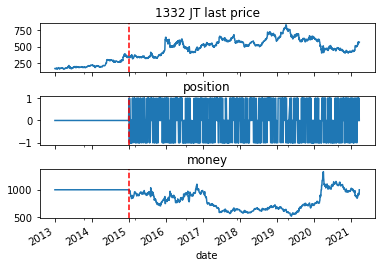

In [7]:
fig, axes = plt.subplots(3, 1, sharex=True)

fig.subplots_adjust(hspace=0.5)
trade_df['last'].plot(ax=axes[0])
trade_df['position'].plot(ax=axes[1])
trade_df['money'].plot(ax=axes[2])

axes[0].set_title(f'{ticker} last price')
axes[1].set_title(f'position')
axes[2].set_title(f'money')

axes[0].axvline(first_trading_date, ls='--', c='r')
axes[1].axvline(first_trading_date, ls='--', c='r')
axes[2].axvline(first_trading_date, ls='--', c='r')
